In [7]:
import xscen as xs
import xarray as xr
import cartopy.crs as ccrs
from xscen.config import CONFIG
import figanos.matplotlib as fg
import matplotlib.pyplot as plt
from plot_settings import make_standardizer, save_plot, DPI
standardize = make_standardizer()
fg.utils.set_mpl_style('ouranos')
import os

# Load configuration
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

2025-08-29 13:55:53 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-08-29 13:55:53 INFO     xscen.config    Updated the config with ../config_obs.yml.


In [8]:
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat.df

id            type processing_level  \
0    ECMWF_ERA5-Land_NAM_reconstruction  reconstruction        extracted   
1        GovCan_RDRS_NAM_reconstruction  reconstruction        extracted   
2        GovCan_CaSR_NAM_reconstruction  reconstruction        extracted   
3     USask_EMDNA_OI_NAM_reconstruction  reconstruction        extracted   
4     PCIC_PCICBlend_CAN_reconstruction  reconstruction        extracted   
..                                  ...             ...              ...   
150                            multiple  reconstruction    regional_mean   
151                            multiple  reconstruction        coherence   
152                            multiple  reconstruction        coherence   
153                            multiple  reconstruction        coherence   
154                            multiple  reconstruction        coherence   

    bias_adjust_institution bias_adjust_project mip_era activity  \
0                       NaN                 NaN     NaN      NaN   
1                       NaN                 NaN     NaN      NaN   
2                       NaN                 NaN     NaN      NaN   
3                       NaN                 NaN     NaN      NaN   
4                       NaN                 NaN     NaN      NaN   
..                      ...                 ...     ...      ...   
150                     NaN                 NaN     NaN      NaN   
151                     NaN                 NaN     NaN      NaN   
152                     NaN                 NaN     NaN      NaN   
153                     NaN                 NaN     NaN      NaN   
154                     NaN                 NaN     NaN      NaN   

    driving_model driving_member institution  ... xrfreq frequency  \
0             NaN            NaN       ECMWF  ...      D       day   
1             NaN            NaN      GovCan  ...      D       day   
2             NaN            NaN      GovCan  ...      D       day   
3             NaN            NaN       USask  ...      D       day   
4             NaN            NaN        PCIC  ...      D       day   
..            ...            ...         ...  ...    ...       ...   
150           NaN            NaN        PCIC  ...     fx       qtr   
151           NaN            NaN        PCIC  ...     fx        yr   
152           NaN            NaN        PCIC  ...     fx        yr   
153           NaN            NaN        PCIC  ...     fx       qtr   
154           NaN            NaN       ECMWF  ...     fx       qtr   

                          variable  domain date_start   date_end version  \
0        (pr, tasmax, tas, tasmin)  Quebec 1980-01-01 2025-05-31     NaN   
1        (pr, tasmax, tas, tasmin)  Quebec 1980-01-01 2018-12-31     v21   
2        (pr, tasmax, tas, tasmin)  Quebec 1980-01-01 2023-12-31     v31   
3        (pr, tasmax, tas, tasmin)  Quebec 1980-01-01 2018-12-31     v10   
4        (pr, tasmax, tas, tasmin)  Quebec 1980-01-01 2012-12-31      v1   
..                             ...     ...        ...        ...     ...   
150       (pr_mean_seasonal_rmse,)  Quebec 1980-03-01 2012-12-01      v1   
151    (tg_mean_annual_clim_mean,)  Quebec 1980-01-01 2012-01-01      v1   
152    (pr_mean_annual_clim_mean,)  Quebec 1980-01-01 2012-01-01      v1   
153  (tg_mean_seasonal_clim_mean,)  Quebec 1980-03-01 2012-12-01      v1   
154  (pr_mean_seasonal_clim_mean,)  Quebec 1980-03-01 2025-03-01     NaN   

    format                                               path  \
0     zarr  /tank/jlavoie/abuyalo/obsflow/extracted/ECMWF_...   
1     zarr  /tank/jlavoie/abuyalo/obsflow/extracted/GovCan...   
2     zarr  /tank/jlavoie/abuyalo/obsflow/extracted/GovCan...   
3     zarr  /tank/jlavoie/abuyalo/obsflow/extracted/USask_...   
4     zarr  /tank/jlavoie/abuyalo/obsflow/extracted/PCIC_P...   
..     ...                                                ...   
150   zarr  /tank/jlavoie/abuyalo/obsflow/regional_mean/mu...   
151   zarr  /tank/jlavoie/abuyalo

In [9]:
def plot(processing_level):    
    dict_ext = pcat.search(processing_level=processing_level).to_dataset_dict()  # Get all datasets with the given processing level
    
    for id, ds in dict_ext.items():  # For each dataset
        if ds.attrs['cat:type'] == 'reconstruction':
            plotting_function = fg.gridmap
            zorder = -3
        else:
            plotting_function = fg.scattermap
            zorder = 1
            
        for var in ds.data_vars:  # For each variable
            var_ds = ds[var]
            coords = var_ds.coords

            if 'lat' in coords and 'lon' in coords:  # Only plot 2D lat/lon
                horizons = [None]
                if 'horizon' in coords:
                    horizons = var_ds.horizon.values
                
                for horizon_val in horizons:
                    sub_ds = var_ds
                    if horizon_val is not None:
                        sub_ds = var_ds.sel(horizon=horizon_val)

                    if 'time' in sub_ds.coords:
                        ith_time = int(len(sub_ds.time) / 2)
                        sub_ds = sub_ds.isel(time=ith_time)
                        show_time = True
                    else:
                        show_time = False

                    # --- build plot_kw dynamically ---
                    plot_kw = {"zorder": zorder}
                    if plotting_function == fg.scattermap:
                        plot_kw["s"] = 5
                        plot_kw["edgecolor"] = "black"
                        plot_kw["linewidths"] = 0.2

                    if 'season' in sub_ds.coords:
                        ax = plotting_function(
                            sub_ds,
                            projection=ccrs.LambertConformal(),
                            fig_kw={"figsize": (20, 5)},
                            plot_kw={**plot_kw, "col": "season"},
                            show_time=show_time,
                            frame=False,
                            enumerate_subplots=True
                        )
                        ax.fig.suptitle(
                            f"{ds.attrs['cat:source']} - Horizon: {horizon_val}",
                            fontsize=16, y=1.04
                        )
                    else:
                        ax = plotting_function(
                            sub_ds,
                            show_time=show_time,
                            plot_kw=plot_kw
                        )
                        ax.set_title(ds.attrs["cat:source"], fontsize=14)
                    
                    standardize(ax)

                    save_plot(
                        ax.figure,
                        processing_level=processing_level,
                        horizon="NA",
                        freq=ds.attrs["cat:xrfreq"],
                        file_name=f"{id}_{var}"
                    )



--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "description" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "description" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "description" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "description" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "description" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "description" not found.
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/utils.py:227: UserWarning: Attribute "description" not

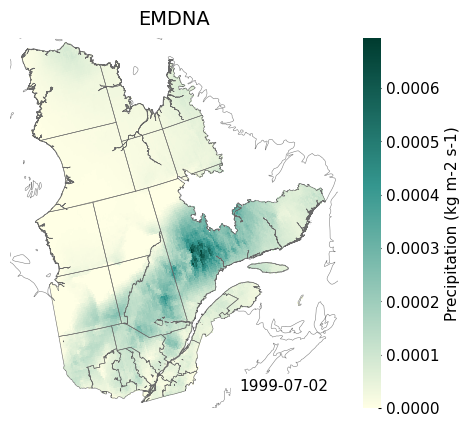

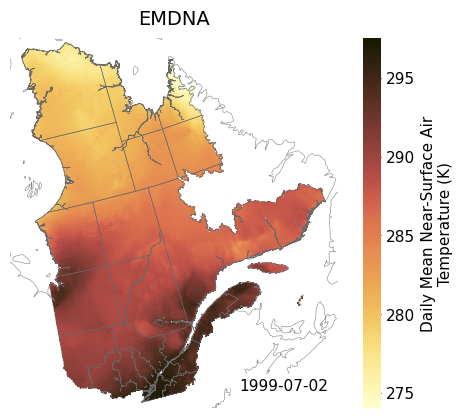

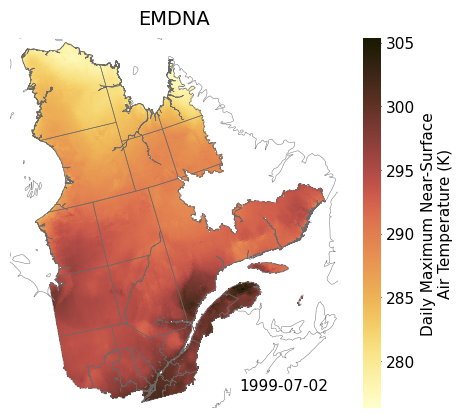

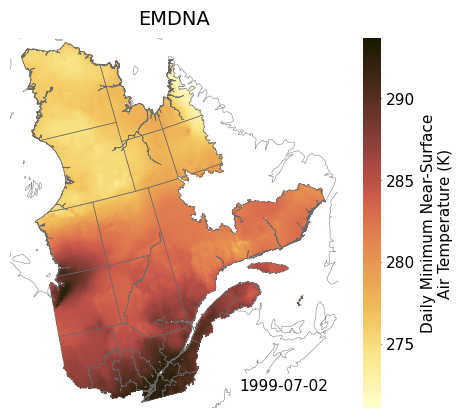

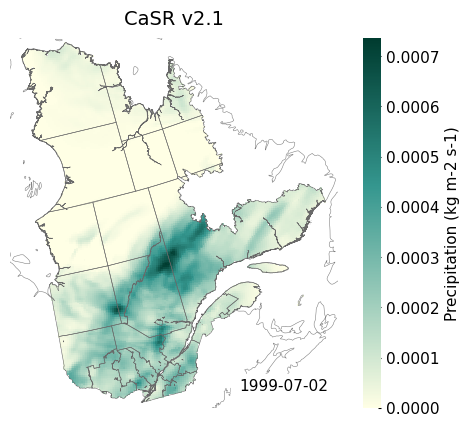

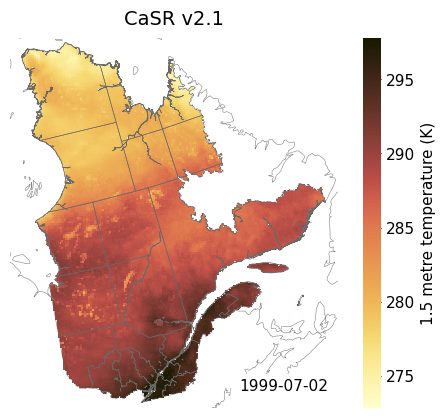

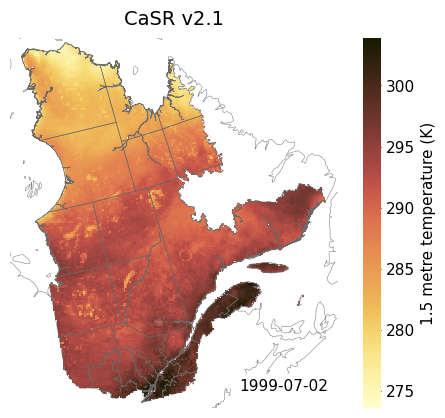

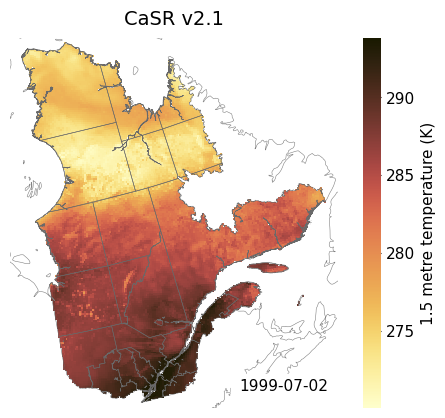

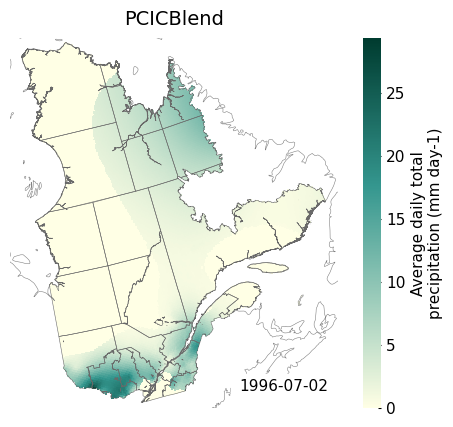

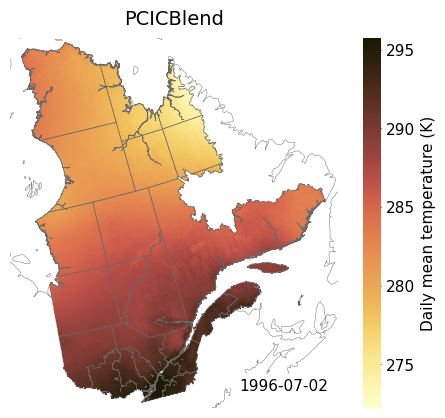

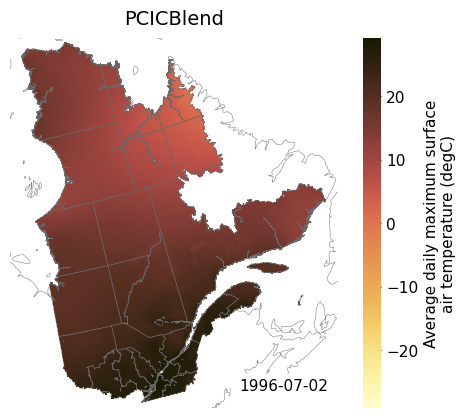

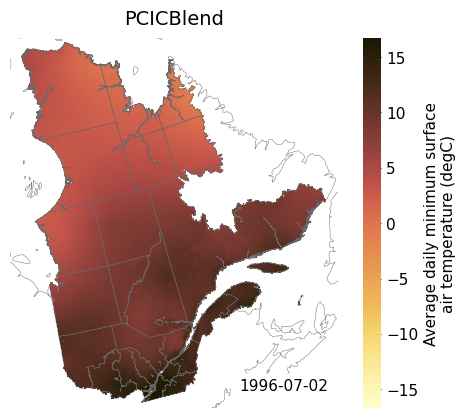

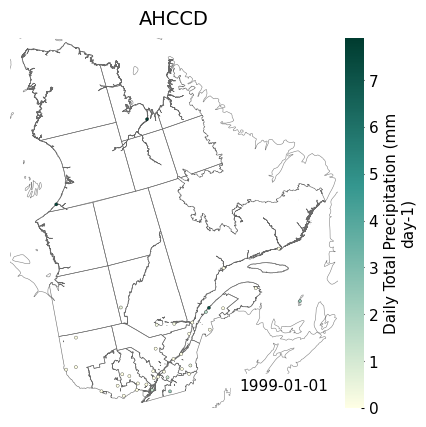

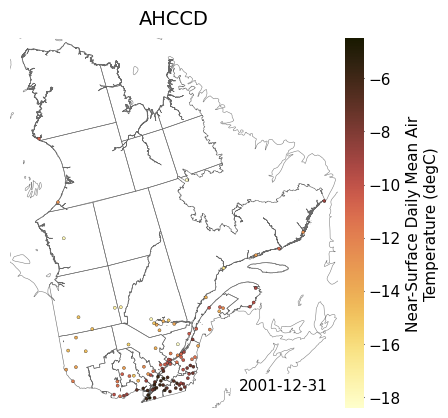

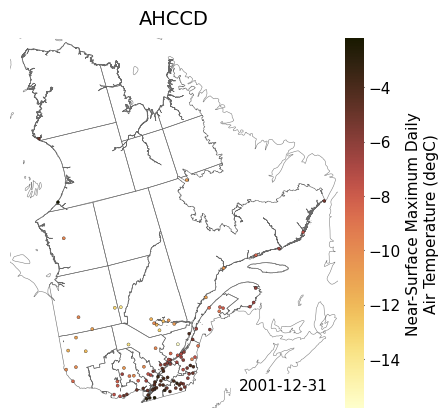

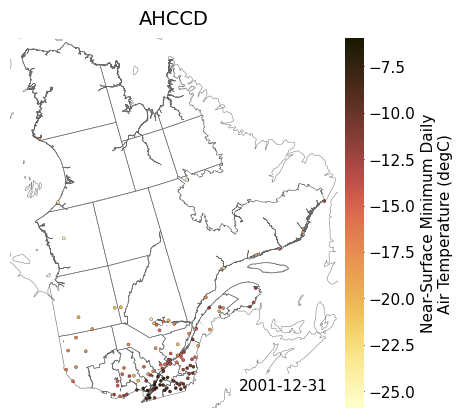

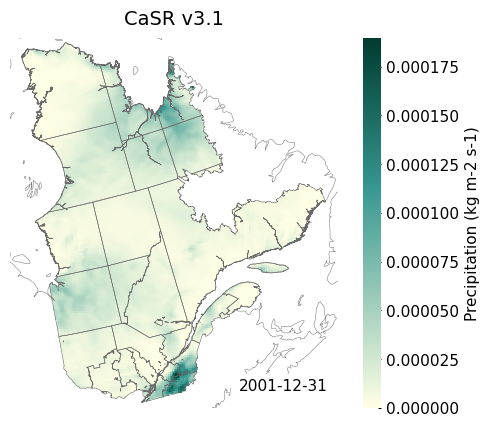

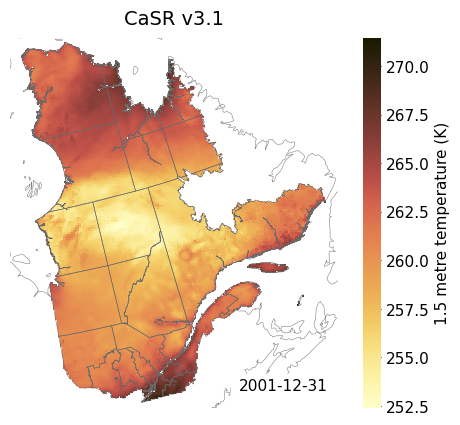

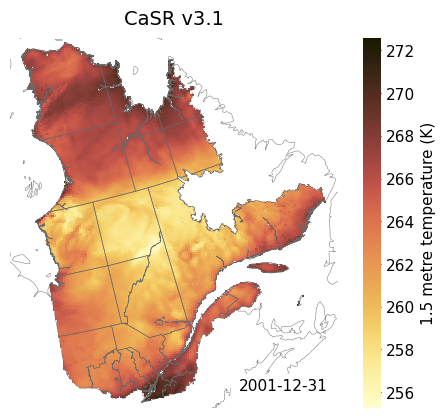

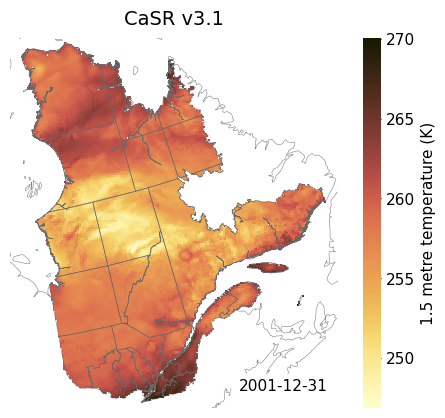

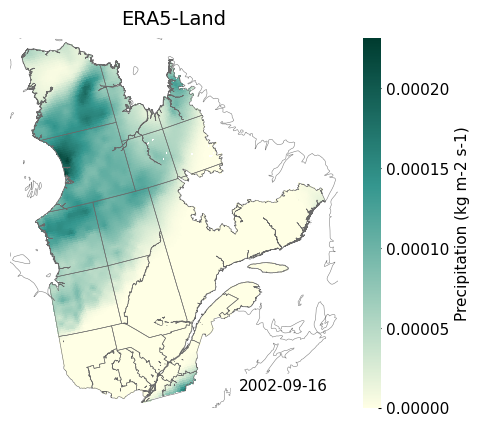

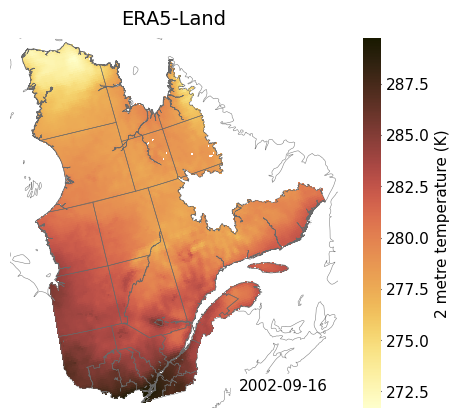

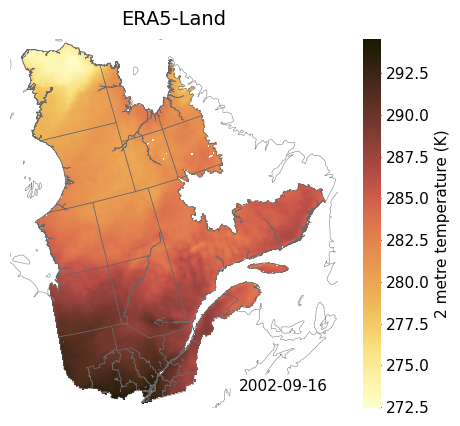

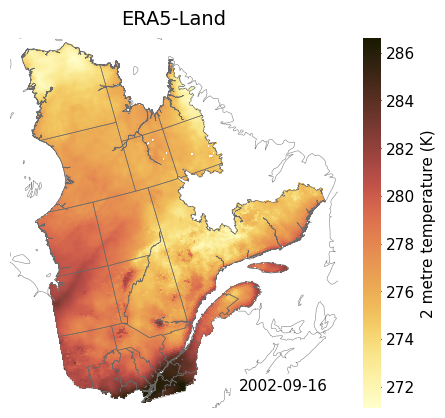

In [10]:
plot(processing_level='extracted')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 20 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 31 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 44 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 46 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 45 nan values were dropped when plotting the color values
/exec/abuyalo/.conda/envs/obsflow/lib/python3.12/site-packages/figanos/matplotlib/plot.py:1748: UserWarning: 37 nan values were dropped when plotting the color value

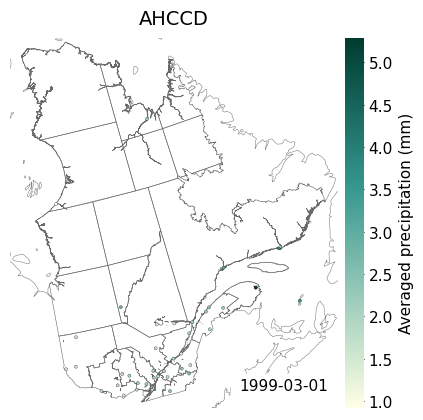

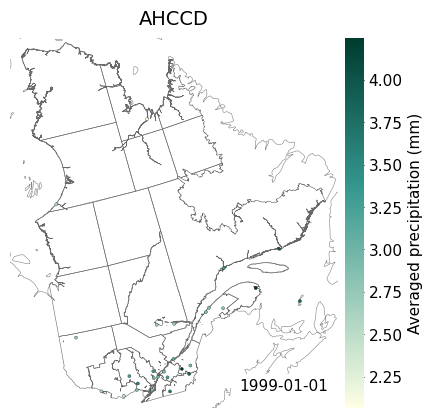

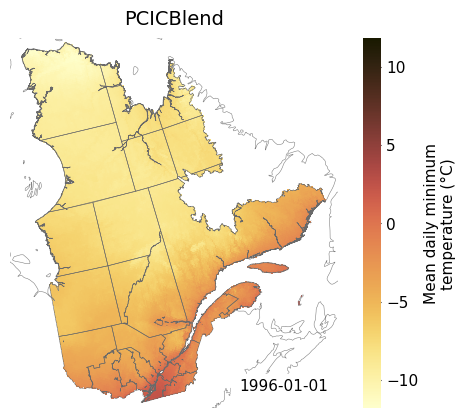

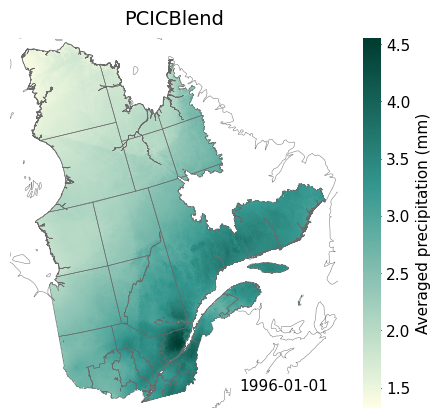

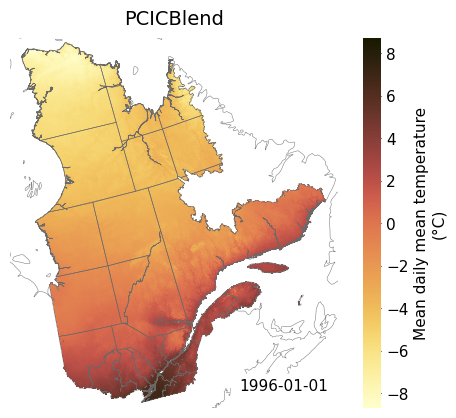

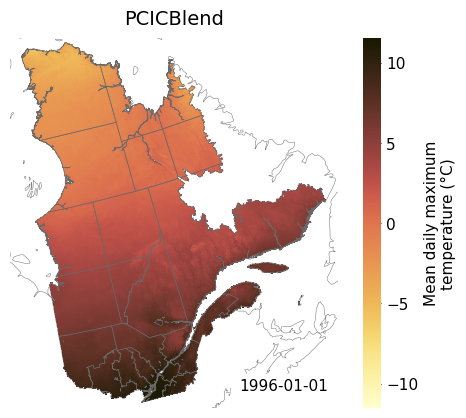

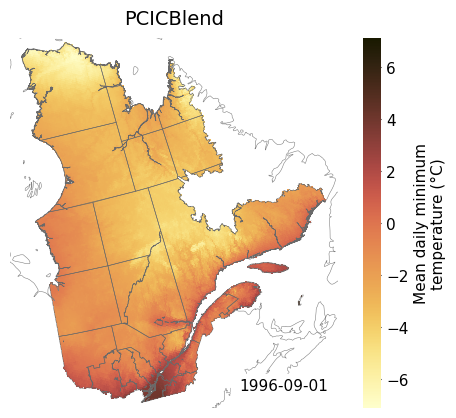

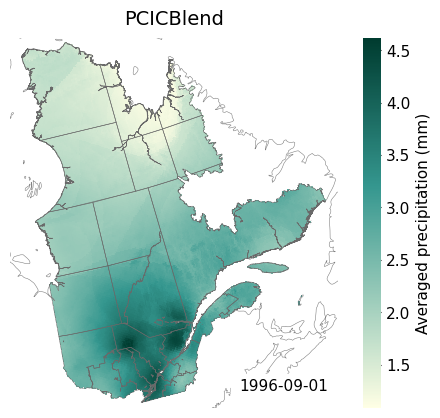

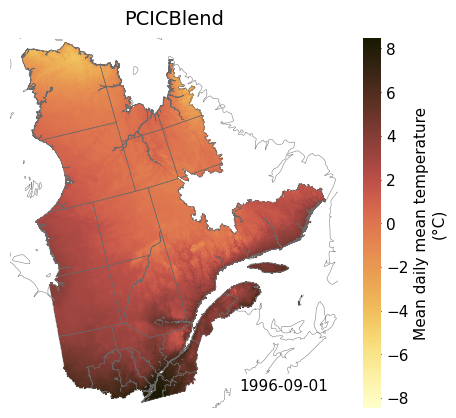

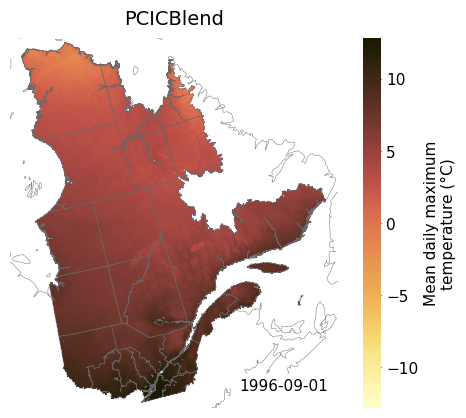

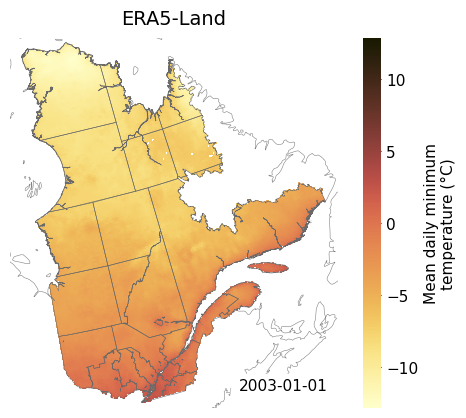

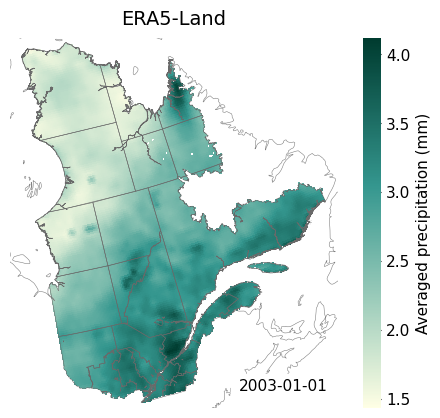

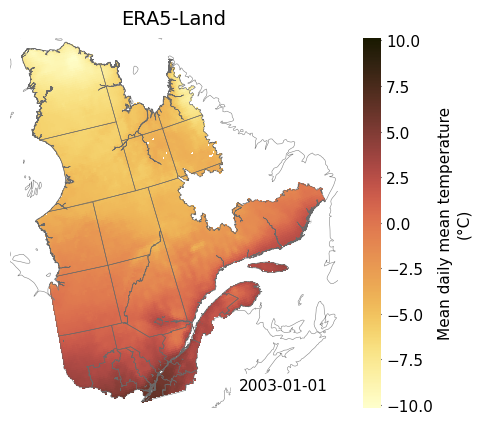

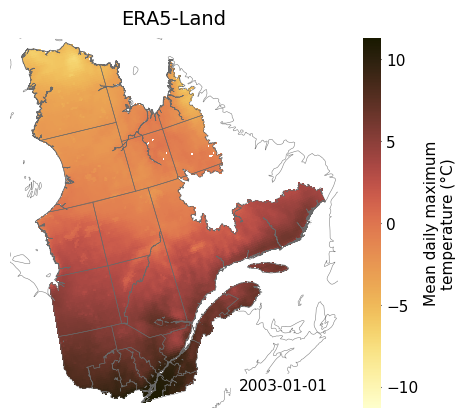

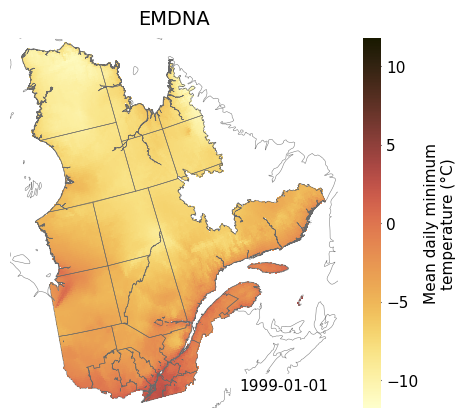

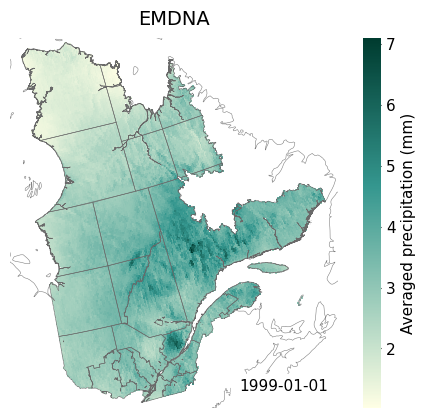

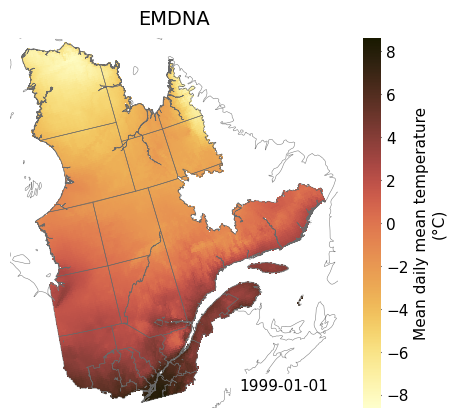

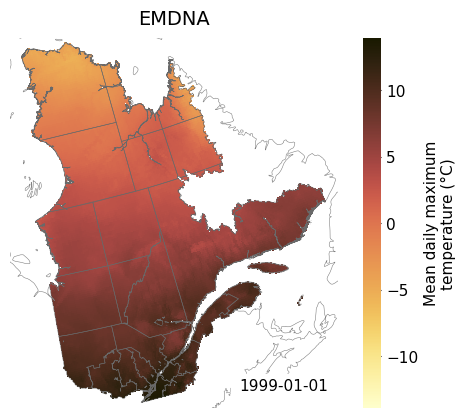

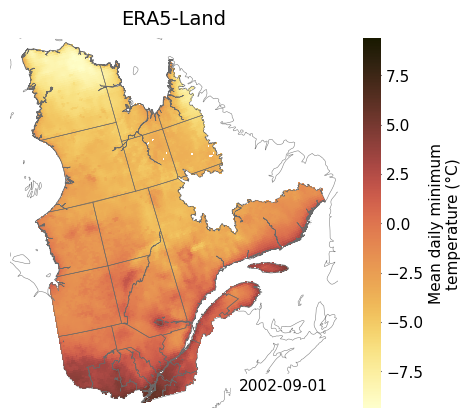

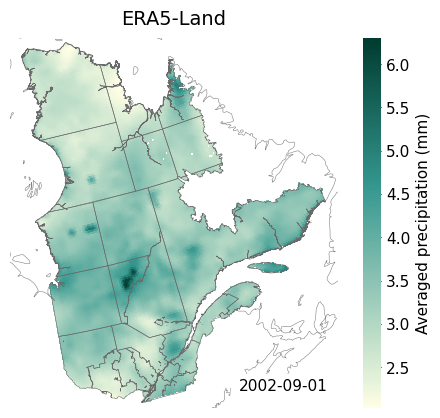

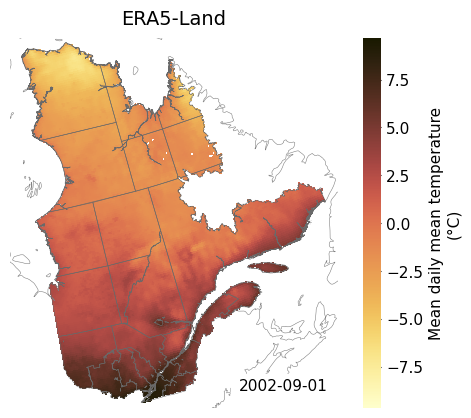

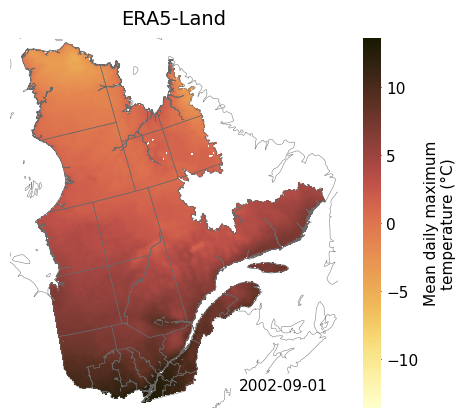

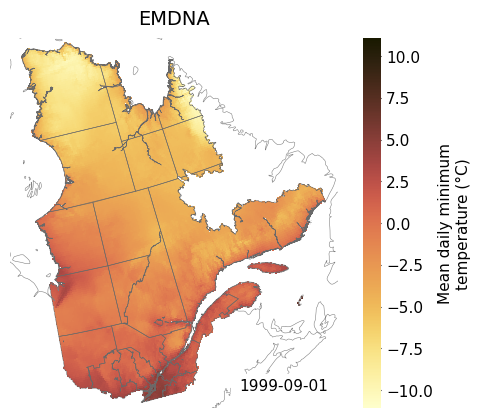

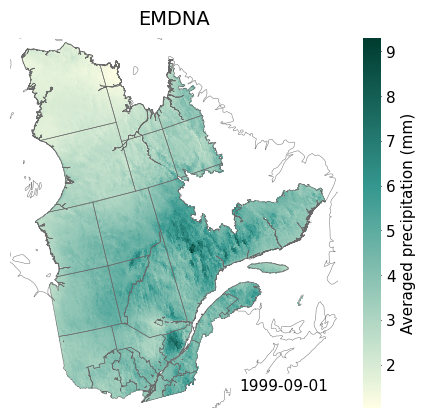

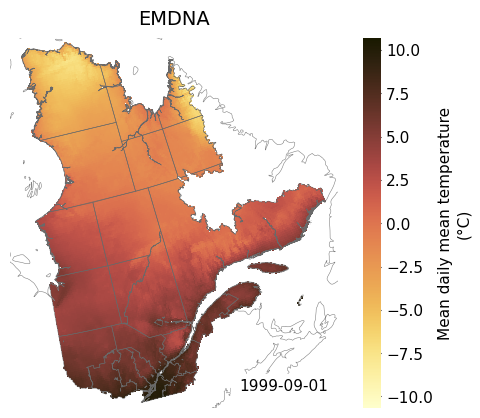

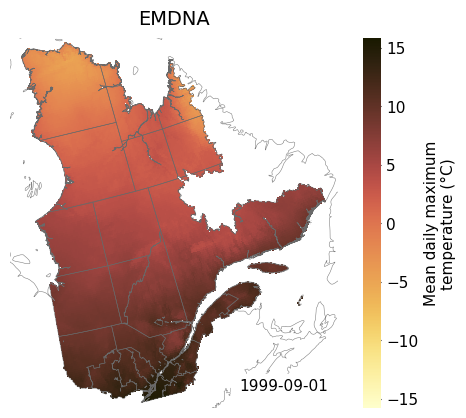

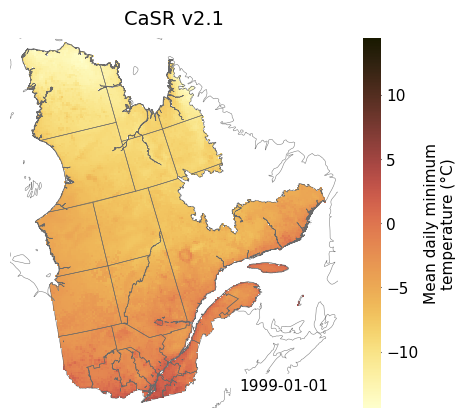

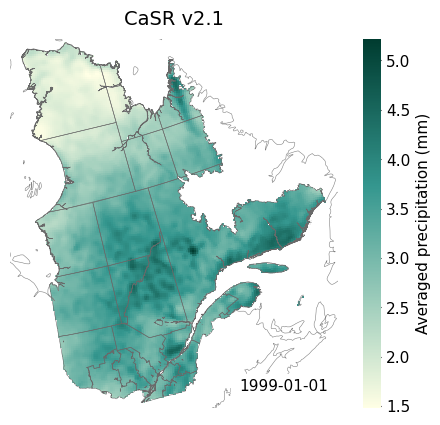

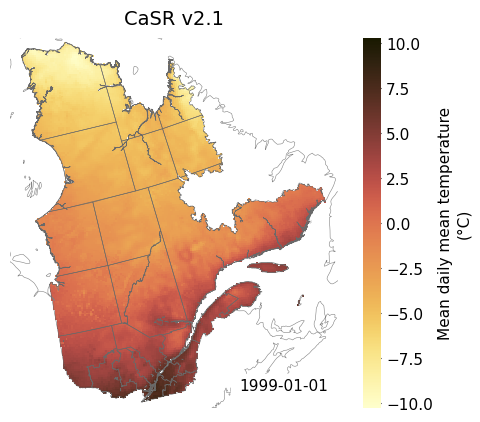

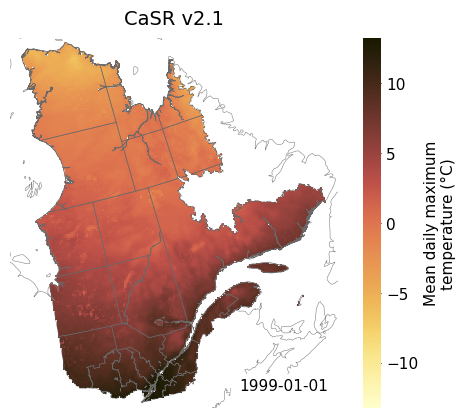

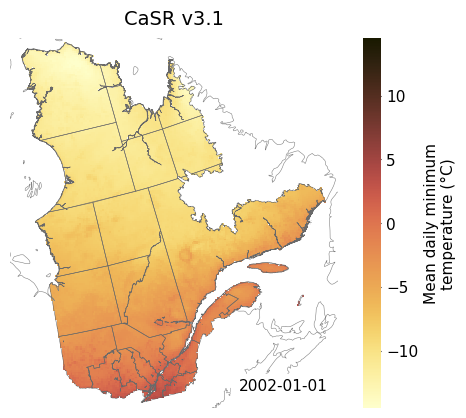

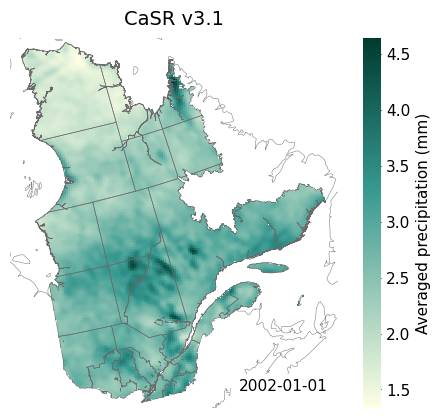

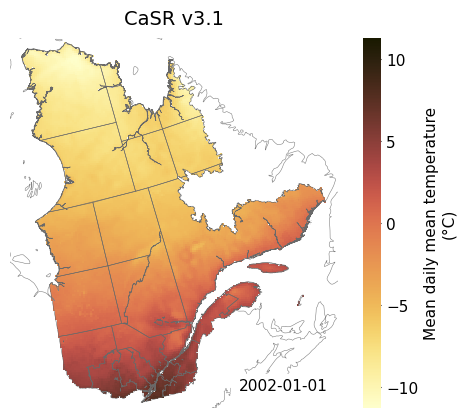

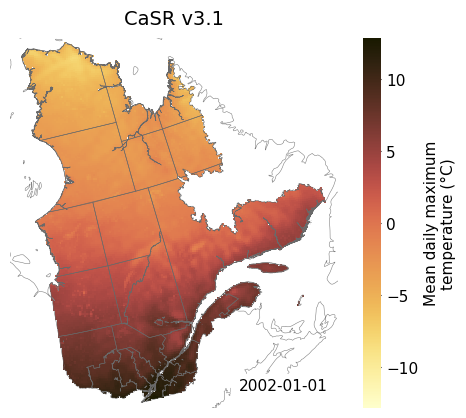

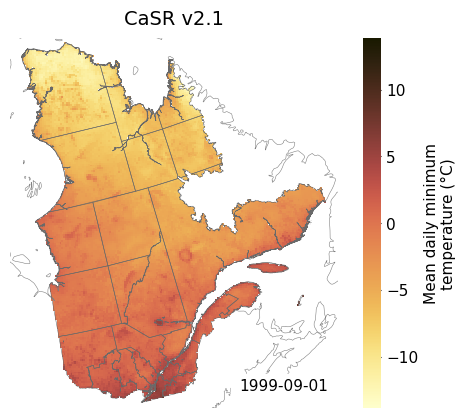

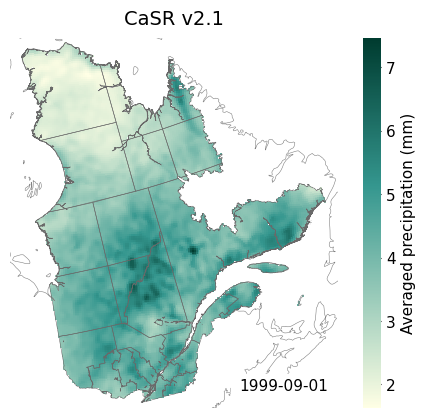

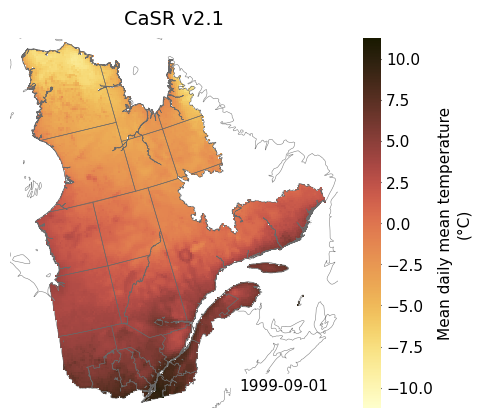

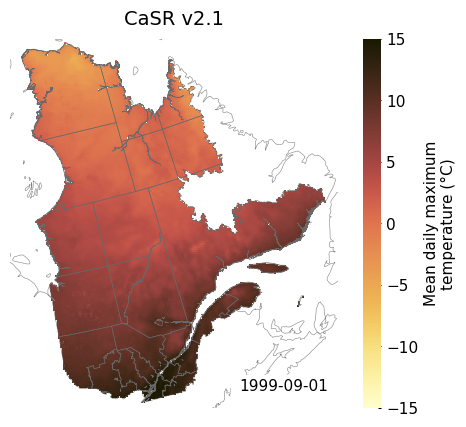

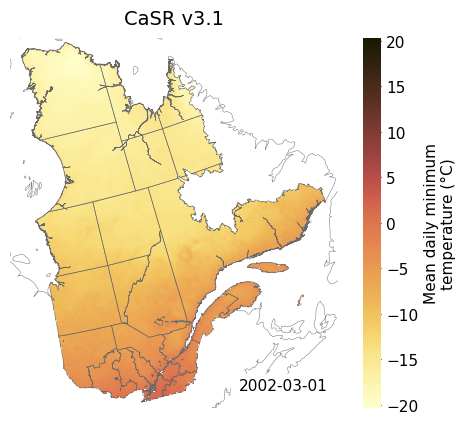

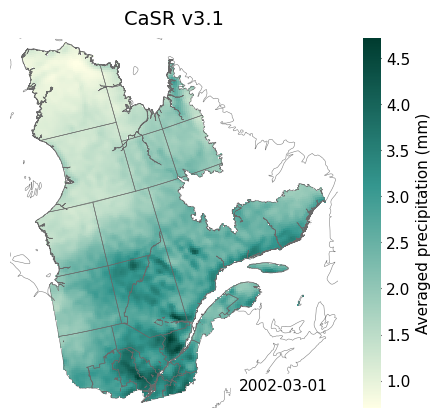

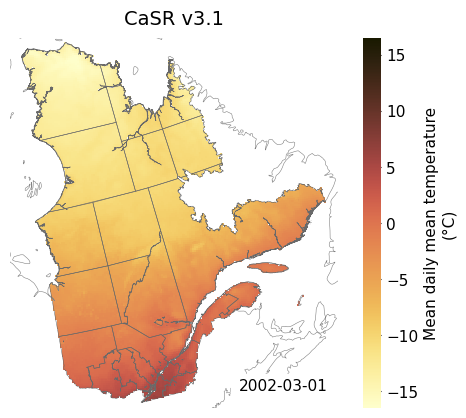

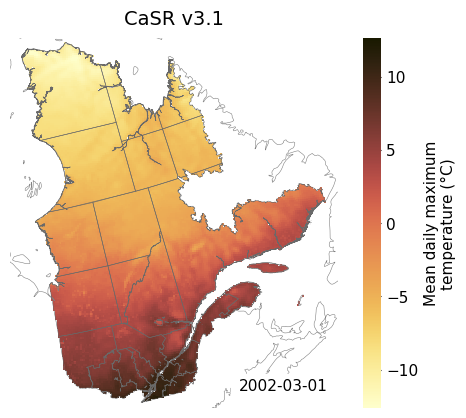

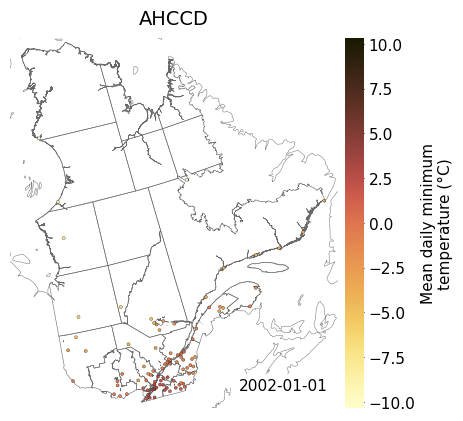

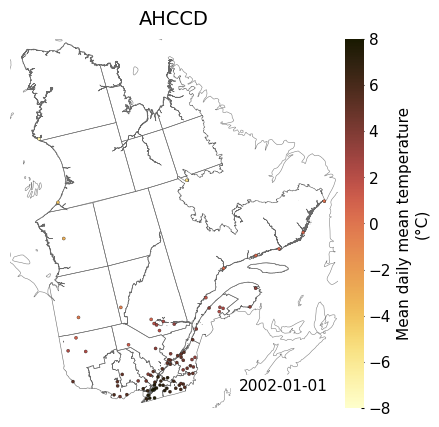

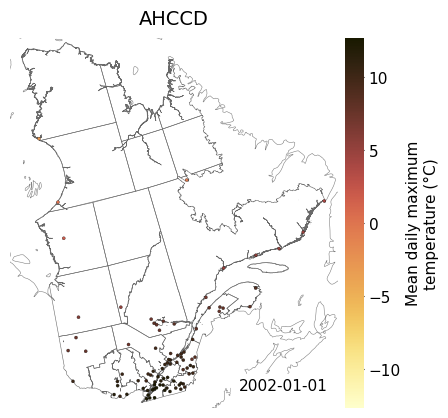

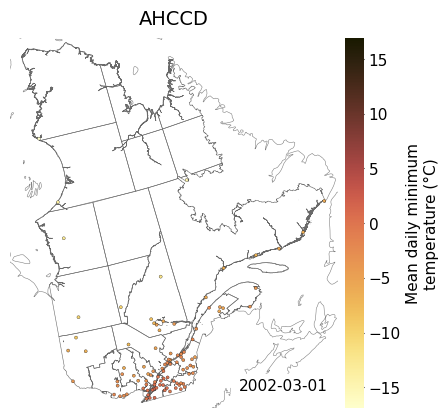

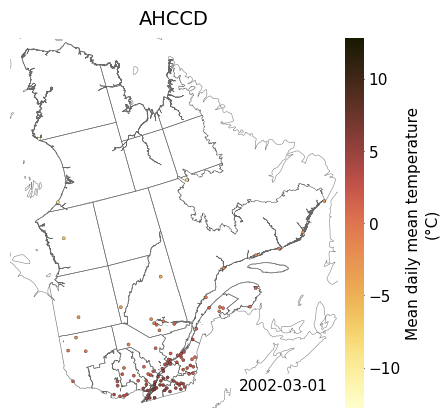

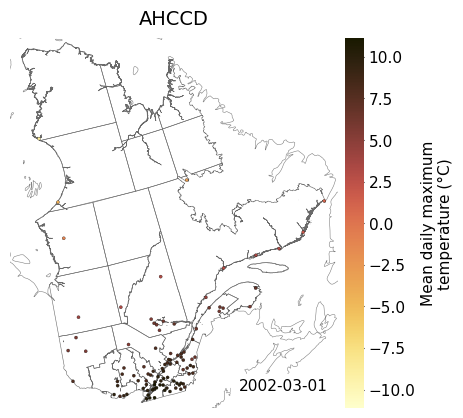

In [11]:
plot(processing_level='indicators')